### Demo of rolling shutter compensation
This notebook provides an example of how rolling shutter and sensor velocity arguments are applied in the rasterization.
While this demonstration focuses on camera rasterization, the same principles also apply to lidar rasterization.

In [1]:
import matplotlib.pyplot as plt
import torch
from gsplat.rendering import rasterization

assert torch.cuda.is_available(), "This demo requires a GPU with CUDA support."
device = torch.device("cuda")

### Setting up the test data

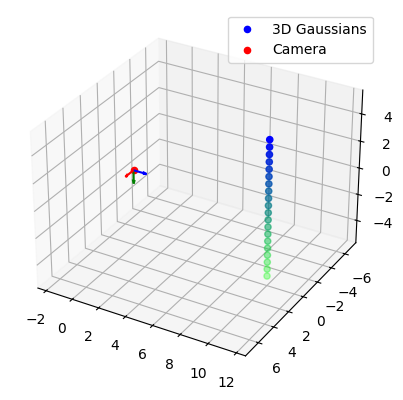

In [2]:
# Gaussian parameters, defined in camera coordinate system for simplicity
N = 20
means = torch.zeros(N, 3, device=device)
means[:, 2] = 10
means[:, 1] = torch.linspace(-5, 5, N, device=device)
quats = torch.tensor([[1., 0., 0., 0.]] * N, device=device)
scales = torch.ones(N, 3, device=device) * 0.1
opacities = torch.ones(N, device=device)
velocities = torch.zeros(N, 3, device=device)
colors = torch.zeros(N, 3, device=device)
colors[:, 1] = torch.linspace(0, 1, N, device=device)
colors[:, 2] = torch.linspace(1, 0, N, device=device)

# Camera parameters
viewmats = torch.tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
], device=device).view(1, 4, 4)
H, W = 500, 500
focal = 500
K = torch.tensor([[focal, 0., W / 2],
                  [0., focal, H / 2],
                  [0., 0., 1.]], device=device).view(1, 3, 3)

# Plot our test data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(means[:, 2].cpu(), means[:, 0].cpu(), -means[:, 1].cpu(), c=colors.cpu(), label="3D Gaussians")
ax.scatter(0, 0, 0, c='r', label='Camera')
ax.quiver(0, 0, 0, 0, 1, 0, color='r') # camera x-axis
ax.quiver(0, 0, 0, 0, 0, -1, color='g') # camera y-axis
ax.quiver(0, 0, 0, 1, 0, 0, color='b') # camera z-axis
ax.axis("equal")
ax.invert_yaxis()
plt.legend()
plt.show()


### Without rolling shutter
The parameters related to rolling shutter are `linear_velocity`, `angular_velocity`, `rolling_shutter_time` and `velocities`:
- Linear and angular velocity: Represent the movement of the sensor (in this case, the camera) within its own coordinate system.
- Rolling shutter time: Indicates the duration required for the sensor to complete a full scan.
- Velocities: The 3D velocities of the Gaussians, expressed in their own coordinate system.

If the sensor's velocity is set to zero, it remains stationary, and no rolling shutter compensation is applied during rasterization.

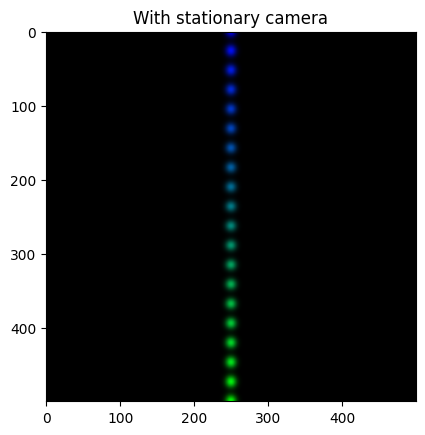

In [3]:
linear_velocity = torch.zeros(1, 3, device=device)
angular_velocity = torch.zeros(1, 3, device=device)
rolling_shutter_time = torch.zeros(1, device=device)

colors_out, _, _ = rasterization(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    colors=colors,
    velocities=velocities,
    viewmats=viewmats,
    Ks=K,
    width=W,
    height=H,
    linear_velocity=linear_velocity,
    angular_velocity=angular_velocity,
    rolling_shutter_time=rolling_shutter_time,
    sh_degree=None,
    render_mode="RGB",
    packed=False,
)

# Plot the image
plt.figure()
plt.imshow(colors_out.squeeze(0).cpu())
plt.title("With stationary camera")
plt.show()

### With rolling shutter compensation
When a sensor moves during capture, it introduces the rolling shutter effect (assuming that the data is not captured instantenous). This effect can be simulated during rasterization by applying appropriate sensor velocities and rolling shutter parameters.

For instance, consider a camera traveling along the x-axis in the camera's coordinate system:

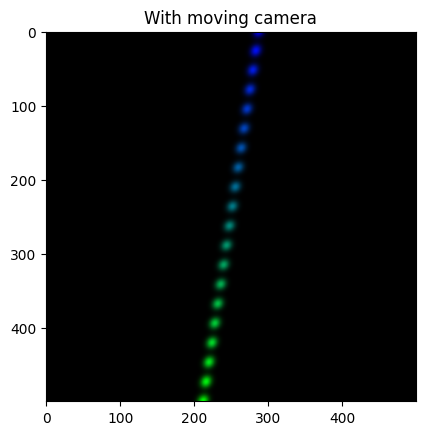

In [4]:
linear_velocity = torch.tensor([[1., 0., 0.]], device=device) * 30
angular_velocity = torch.zeros(1, 3, device=device)
rolling_shutter_time = torch.ones(1, device=device) * 0.05

colors_out, _, _ = rasterization(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    colors=colors,
    velocities=velocities,
    viewmats=viewmats,
    Ks=K,
    width=W,
    height=H,
    linear_velocity=linear_velocity,
    angular_velocity=angular_velocity,
    rolling_shutter_time=rolling_shutter_time,
    sh_degree=None,
    render_mode="RGB",
    packed=False,
)

# Plot the image
plt.figure()
plt.imshow(colors_out.squeeze(0).cpu())
plt.title("With moving camera")
plt.show()

The rolling shutter time can be adjusted to simulate a slower camera capture:

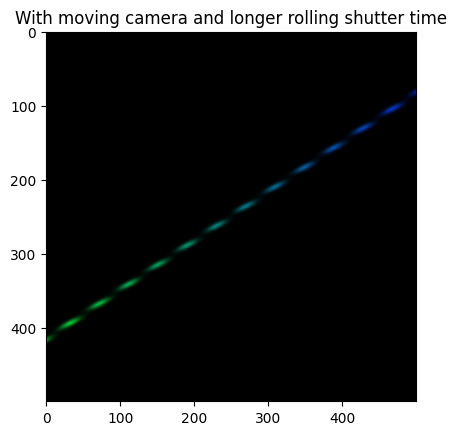

In [5]:
linear_velocity = torch.tensor([[1., 0., 0.]], device=device) * 30
angular_velocity = torch.zeros(1, 3, device=device)
rolling_shutter_time = torch.ones(1, device=device) * 0.5

colors_out, _, _ = rasterization(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    colors=colors,
    velocities=velocities,
    viewmats=viewmats,
    Ks=K,
    width=W,
    height=H,
    linear_velocity=linear_velocity,
    angular_velocity=angular_velocity,
    rolling_shutter_time=rolling_shutter_time,
    sh_degree=None,
    render_mode="RGB",
    packed=False,
)

# Plot the image
plt.figure()
plt.imshow(colors_out.squeeze(0).cpu())
plt.title("With moving camera and longer rolling shutter time")
plt.show()

Angular velocities can also contribute to the rolling shutter effect:

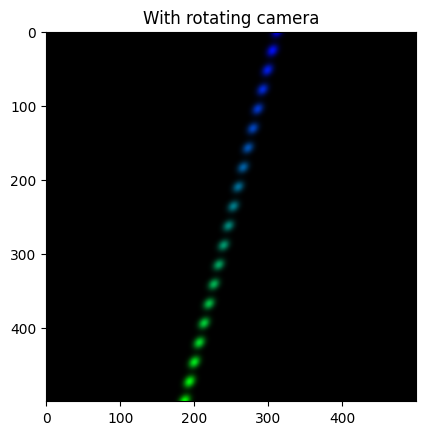

In [6]:
linear_velocity = torch.zeros(1, 3, device=device)
angular_velocity = torch.tensor([[0., 1., 0.]], device=device) * 5.0
rolling_shutter_time = torch.ones(1, device=device) * 0.05

colors_out, _, _ = rasterization(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    colors=colors,
    velocities=velocities,
    viewmats=viewmats,
    Ks=K,
    width=W,
    height=H,
    linear_velocity=linear_velocity,
    angular_velocity=angular_velocity,
    rolling_shutter_time=rolling_shutter_time,
    sh_degree=None,
    render_mode="RGB",
    packed=False,
)

# Plot the image
plt.figure()
plt.imshow(colors_out.squeeze(0).cpu())
plt.title("With rotating camera")
plt.show()

The rolling shutter effect can also appear in stationary sensors when observing fast-moving objects. This can be simulated using the `velocities` argument:

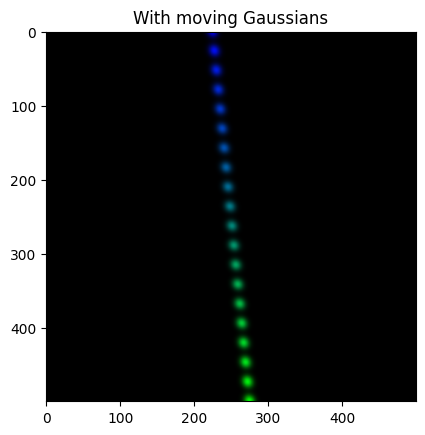

In [7]:
linear_velocity = torch.zeros(1, 3, device=device)
angular_velocity = torch.tensor([[0., 1., 0.]], device=device)
rolling_shutter_time = torch.ones(1, device=device) * 0.05
velocities[:, 0] = 30.0

colors_out, _, _ = rasterization(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    colors=colors,
    velocities=velocities,
    viewmats=viewmats,
    Ks=K,
    width=W,
    height=H,
    linear_velocity=linear_velocity,
    angular_velocity=angular_velocity,
    rolling_shutter_time=rolling_shutter_time,
    sh_degree=None,
    render_mode="RGB",
    packed=False,
)

# Plot the image
plt.figure()
plt.imshow(colors_out.squeeze(0).cpu())
plt.title("With moving Gaussians")
plt.show()